In [6]:
model = "musse"
trees_directory = "trees/"
num_states = 3

In [3]:
import os
import numpy as np
from ete3 import Tree

class TreeEncoder:

    def encode_tree(self, tree_str):
        """
        Encode the tree structure into a format suitable for input into the neural network.
        """
        # Check if the tree is already encoded
        csv_file = tree_str[:-4] + '.csv'
        if os.path.exists(csv_file):
            return csv_file
        # Call the external script to get CDV encoding
        cmd = f"python -m CDV_full_tree -t {tree_str}" # > {tree_str[:-4]}.csv"
        os.system(cmd)
        

    def encode_all_trees(self, trees_directory):
        """
        Encode all the trees in the given directory.
        """
        tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]
        for tree_file in tree_files:
            print(tree_file)
            self.encode_tree(tree_file)


In [2]:
import sys

encoder = TreeEncoder()
encoded_trees = encoder.encode_all_trees(trees_directory)

trees/bd.nwk
trees/bisse.nwk
trees/bisseness.nwk
trees/classe.nwk
trees/geosse.nwk
trees/musse.nwk
trees/quasse.nwk


Check if the musse.csv is empty, in that case run
* python -m CDV_full_tree -t trees/musse.nwk

from linux terminal!

In [13]:
import pandas as pd

# Load parameter values as a dataframe
tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]


if model == "bd":
    column_names = ['lambda', 'mu']
elif model == "bisse":
    column_names = ['lambda0', 'lambda1', 'mu0', 'mu1', 'q01', 'q10']
elif model == "musse":
    '''
    λ1, . . . , λK, µ1, . . . , µK, qij
    Generalizing BiSSE to K
    character states with constant
    rates.
    '''
    if num_states == 3:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'mu1', 'mu2', 'mu3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
    elif num_states == 4:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'lambda4', 'mu1', 'mu2', 'mu3', 'mu4', 'q12', 'q13', 'q14', 'q21', 'q23', 'q24', 'q31', 'q32', 'q34', 'q41', 'q42', 'q43']
    elif num_states == 5:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'lambda4', 'lambda5', 'mu1', 'mu2', 'mu3', 'mu4', 'mu5', 'q12', 'q13', 'q14', 'q15', 'q21', 'q23', 'q24', 'q25', 'q31', 'q32', 'q34', 'q35', 'q41', 'q42', 'q43', 'q45', 'q51', 'q52', 'q53', 'q54']
    else:
        print("Not implemented for more than 5 states")
elif model == "geosse":
    '''
    sA, sB, sAB, xA, xB, dA, dB    
    Accounts for geographical
    considerations with constant
    rates of speciation, extinction,
    and dispersal.'''
    column_names = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
elif model == "bisseness":
    '''
    λ0, λ1, µ0, µ1, q12, q21, p0c, p0a, p1c, p1a
    Estimates rates of change occurring along lineages and
    probabilities of change during
    speciation.
    '''
    column_names = ['lambda0', 'lambda1', 'mu0', 'mu1', 'q12', 'q21', 'p0c', 'p0a', 'p1c', 'p1a']
elif model == "classe":
    '''
    λklm (where 1 ≤ k, l, m ≤ n),
    µk (where 1 ≤ k ≤ n),
    qlm (where 1 ≤ l ̸= m ≤ n)
    Distinguishes between anagenetic and cladogenetic speciation with variable rates.
    There will be n^2 cladogenesis rates and n extinction rates
    plus n(n-1) transition rates, making a total of n^2+n+n(n-1) parameters.
    
    Two character states:
    • λ111: Rate of cladogenesis generating progeny inheriting the first character
    state if the parent already possessed said attribute.
    • λ112: Rate of cladogenesis leading to descendants adopting the second
    character state when parents initially bore the initial feature.
    • λ122: Analogous scenario but with reversed roles in character acquisition
    order.
    3
    Figure 2: Anagenesis and Cladogenesis.
    • λ211: Another case wherein children adopt the first characteristic after the
    parent had shifted to the second configuration.
    • λ212: Identical context as above except the final outcome reflects the emergence of the second character state in offspring.
    • λ222: Parallel situation to the preceding cases yet with both parents and
    descendants uniformly exhibiting the latter trait.
    • µ1: Extinction rate attributed to the primary character state.
    • µ2: Loss rate ascribed to the secondary character state.
    • q12: Shift rate towards obtaining the second character state starting from
    the first.
    • q21: Reverse transformation rate moving away from the first characteristic
    toward attaining the second.
    '''
    if num_states == 2:
        column_names = ['lambda111', 'lambda112', 'lambda122', 'lambda211', 'lambda212', 'lambda222', 'mu1', 'mu2', 'q12', 'q21']
    else:
        print("Not implemented yet for more than 2 states")
        
    


def process_params(param_file):
    # Reads the parameter file and saves the values in a csv file, one tree per row.
    # If the parameter file is already in the csv format, return
    if param_file.endswith('.csv'):
        return
    with open(param_file, 'r') as f:
        lines = f.readlines()
    param_values = []
    for line in lines:
        if line.startswith('num_states'):
            param_values.append([])
        else:
            param_values[-1].append(line.split()[1])
    param_df = pd.DataFrame(param_values)
    param_df.to_csv(param_file + '.csv', sep='\t', header=False, index=False)
        
        
    
    
param_file = trees_directory + model + '.params'
process_params(param_file)


cutoff = 0.8  # Number of train trees
param = pd.read_csv(param_file + '.csv' , sep='\t', header=None)

cutoff = int(cutoff * param.shape[0])

param_train = param.iloc[:cutoff, :]
param_test = param.iloc[cutoff:, :]

# Check that the number of columns is correct
assert param_train.shape[1] == len(column_names)

print(param_train.shape)
print(param_test.shape)



def rename_columns(df, names):
    df = df.rename(columns={i: names[i] for i in df.columns})
    return df

param_train = rename_columns(param_train, column_names)
param_test = rename_columns(param_test, column_names)

# loading tree encodings/representations
# encoding has the following structure: 1 value of tree height, 500 values for tip states ('1' or '2')
# 1 value for tree height and 500 values for internal node heights
# + 2 values for nb of tips of each type (to be removed) and 1 value of rescaling (removed, but stocked for rescaling predicted values back to the original scale)

# split the encoding into train and test (cutoff is 0.8% of the data)
# read csv and know that there are empty rows for each row of the dataframe
encoding = pd.read_csv(trees_directory + model + '.csv', sep='\t', header=None, skiprows=1, index_col=0)

encoding_train = encoding.iloc[:cutoff, :]
encoding_test = encoding.iloc[cutoff:, :]

print(encoding_train.shape)
print(encoding_test.shape)

print("Number of trees in parameters file: ", param.shape[0])
print("Number of trees in encoding file: ", encoding.shape[0])



# make sure there is correspondance between indexes of dataframe with parameter values and encodings
encoding_train.index = param_train.index
encoding_test.index = param_test.index


# part of the relative path for writing down the output files
chemin = './trained_models/' + model + '/'

# the suffix of output files
expname='90k'

# check
param_test

# check
print(encoding_test.shape)
print(param_train)

# check
encoding_test

(72490, 12)
(18123, 12)
(72490, 1002)
(18123, 1002)
Number of trees in parameters file:  90613
Number of trees in encoding file:  90613
(18123, 1002)
        lambda1   lambda2   lambda3       mu1       mu2       mu3       q12  \
0      0.267270  0.334438  0.460898  0.242737  0.067450  0.414066  0.855740   
1      0.352334  0.391563  0.541256  0.118008  0.175253  0.042047  0.593497   
2      0.614129  0.169446  0.402505  0.084064  0.080953  0.237404  0.540157   
3      0.541851  0.240000  0.575899  0.388022  0.227043  0.016148  0.151547   
4      0.633238  0.462413  0.645760  0.509354  0.437419  0.003008  0.271211   
...         ...       ...       ...       ...       ...       ...       ...   
72485  0.138039  0.391447  0.150160  0.036908  0.176935  0.032424  0.588841   
72486  0.623076  0.476794  0.175784  0.100626  0.296484  0.136390  0.572212   
72487  0.508424  0.347398  0.633455  0.366444  0.042928  0.334501  0.209224   
72488  0.616304  0.349710  0.113534  0.204601  0.286525  0.0

,1,2,3,4,5,6,7,8,9,10,...,993,994,995,996,997,998,999,1000,1001,1002
72490,12.240602,10.653679,11.561691,10.434165,10.844173,9.577235,10.403342,11.855520,8.150592,11.638568,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.446994
72491,7.071026,6.584305,5.705461,6.686789,5.135640,6.157851,6.993264,6.118795,6.929555,4.616431,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.517741
72492,10.885501,9.170570,9.033491,9.605471,10.218459,10.698478,8.567155,9.498542,10.861188,7.816456,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.189007
72493,20.585337,18.723736,20.330548,20.494294,20.232907,18.915780,20.190828,18.691614,20.029787,17.706502,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,3.999878
72494,16.664284,15.924803,15.899505,16.178602,15.866248,16.585373,16.569777,16.509280,15.714358,15.357432,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.751073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90608,19.299491,18.491352,18.989641,18.470690,18.024151,18.924629,18.705650,17.378682,17.517248,17.258251,...,17.258036,12.644134,18.521532,16.778352,18.525579,0.0,0.0,0.0,0.0,1.599951
90609,14.470817,12.792597,14.207768,12.609248,12.289739,13.237261,10.951384,10.881445,13.710616,13.114480,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.052325
90610,18.733520,17.609935,17.140132,17.072169,17.493674,18.505366,18.405317,16.324967,17.093485,16.029290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.985297
90611,9.362905,8.197653,8.886496,8.122103,7.692612,8.162234,8.912225,9.362905,7.793750,8.643318,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.337621


In [14]:
'''
#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):

### TRAINING SET: PARAMETER VALUES
# rescaling factor
param_train['norm_factor'] = encoding_train[502]
print(param_train['norm_factor'])
# rescale target values according to scaling factor
param_train['net_rat1_rescaled'] = param_train['net_rate1']*param_train['norm_factor']
param_train['net_rat2_rescaled'] = param_train['net_rate2']*param_train['norm_factor']
param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
param_train['q01_rescaled'] = param_train['q01']*param_train['norm_factor']

### TESTING SET: PARAMETER VALUES
# rescaling factor
param_test['norm_factor'] = encoding_test[1005]
# rescale target values
param_test['net_rat1_rescaled'] = param_test['net_rate1']*param_test['norm_factor']
param_test['net_rat2_rescaled'] = param_test['net_rate2']*param_test['norm_factor']
param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
param_test['q01_rescaled'] = param_test['q01']*param_test['norm_factor']

# remove irrelevant columns: count of each type of tip and normalization factor
encoding_train.drop(columns=[1003, 1004, 1005], axis=1, inplace=True)
encoding_test.drop(columns=[1003, 1004, 1005], axis=1, inplace=True)
'''

"\n#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):\n\n### TRAINING SET: PARAMETER VALUES\n# rescaling factor\nparam_train['norm_factor'] = encoding_train[502]\nprint(param_train['norm_factor'])\n# rescale target values according to scaling factor\nparam_train['net_rat1_rescaled'] = param_train['net_rate1']*param_train['norm_factor']\nparam_train['net_rat2_rescaled'] = param_train['net_rate2']*param_train['norm_factor']\nparam_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']\nparam_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']\nparam_train['q01_rescaled'] = param_train['q01']*param_train['norm_factor']\n\n### TESTING SET: PARAMETER VALUES\n# rescaling factor\nparam_test['norm_factor'] = encoding_test[1005]\n# rescale target values\nparam_test['net_rat1_rescaled'] = param_test['net_rate1']*param_test['norm_factor']\nparam_test['net_rat2_rescaled'] = param_test['net_rate2']*para

In [15]:
encoding_train.shape
# Write to csv
param_train.to_csv(chemin + '/param_train' + expname + '.csv')
param_test.to_csv(chemin + '/param_test' + expname + '.csv')
encoding_train.to_csv(chemin + '/encoding_train' + expname + '.csv')
encoding_test.to_csv(chemin + '/encoding_test' + expname + '.csv')

In [20]:
# Read the data
param_train = pd.read_csv(chemin + '/param_train' + expname + '.csv', index_col=0)
param_test = pd.read_csv(chemin + '/param_test' + expname + '.csv', index_col=0)
encoding_train = pd.read_csv(chemin + '/encoding_train' + expname + '.csv', index_col=0)
encoding_test = pd.read_csv(chemin + '/encoding_test' + expname + '.csv', index_col=0)



#Choice of the parameters to predict

predict_all = True
if not predict_all:
    if model == "musse":
        target1 = 'lambda1'
        target2 = 'lambda2'
        target3 = 'lambda3'
        target4 = 'mu1'
        target5 = 'mu2'
        target6 = 'mu3'
        target7 = 'q12'
        target8 = 'q13'
        target9 = 'q21'
        target10 = 'q23'
        target11 = 'q31'
        target12 = 'q32'
        
        targets = pd.DataFrame(param_train[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12])
        targets_test = pd.DataFrame(param_test[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12])
        
    elif model == "bd":
        target1 = 'lambda'
        target2 = 'mu'
        
        targets = pd.DataFrame(param_train[target1, target2])
        targets_test = pd.DataFrame(param_test[target1, target2])
        
    elif model == "bisse":
        target1 = 'lambda0'
        target2 = 'lambda1'
        target3 = 'mu0'
        target4 = 'mu1'
        target5 = 'q01'
        target6 = 'q10'
        
        targets = pd.DataFrame(param_train[target1, target2, target3, target4, target5, target6])
        targets_test = pd.DataFrame(param_test[target1, target2, target3, target4, target5, target6])
        
    elif model == "geosse":
        target1 = 'sA'
        target2 = 'sB'
        target3 = 'sAB'
        target4 = 'xA'
        target5 = 'xB'
        target6 = 'dA'
        target7 = 'dB'
        
        targets = pd.DataFrame(param_train[target1, target2, target3, target4, target5, target6, target7])
        targets_test = pd.DataFrame(param_test[target1, target2, target3, target4, target5, target6, target7])
        
    elif model == "bisseness":
        target1 = 'lambda0'
        target2 = 'lambda1'
        target3 = 'mu0'
        target4 = 'mu1'
        target5 = 'q12'
        target6 = 'q21'
        target7 = 'p0c'
        target8 = 'p0a'
        target9 = 'p1c'
        target10 = 'p1a'
        
        targets = pd.DataFrame(param_train[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10])
        targets_test = pd.DataFrame(param_test[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10])
        
    elif model == "classe":
        target1 = 'lambda111'
        target2 = 'lambda112'
        target3 = 'lambda122'
        target4 = 'lambda211'
        target5 = 'lambda212'
        target6 = 'lambda222'
        target7 = 'mu1'
        target8 = 'mu2'
        target9 = 'q12'
        target10 = 'q21'
        
        targets = pd.DataFrame(param_train[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10])
        targets_test = pd.DataFrame(param_test[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10])
    
else:
    
    targets = param_train
    targets_test = param_test
    
features = encoding_train
features_test = encoding_test

# how large is the validation set in percentage of the total number of trees
valid_frac = 0.2
train_size_frac = 1 - valid_frac

In [21]:
print("Validation set fraction: ", valid_frac)
print("Training set fraction: ", train_size_frac)

Validation set fraction:  0.2
Training set fraction:  0.8


In [7]:
    """
    #Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)
    add_target = "sampling_frac"
    added_targets = pd.DataFrame(param_train[add_target])
    features['1003'] = added_targets
    features['1004'] = added_targets
    features['1005'] = added_targets
    features['1006'] = added_targets
    features['1007'] = added_targets
    features['1008'] = added_targets

    added_targets2 = pd.DataFrame(param_test[add_target])
    features_test['1003'] = added_targets2
    features_test['1004'] = added_targets2
    features_test['1005'] = added_targets2
    features_test['1006'] = added_targets2
    features_test['1007'] = added_targets2
    features_test['1008'] = added_targets2
    """

'\n#Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)\nadd_target = "sampling_frac"\nadded_targets = pd.DataFrame(param_train[add_target])\nfeatures[\'1003\'] = added_targets\nfeatures[\'1004\'] = added_targets\nfeatures[\'1005\'] = added_targets\nfeatures[\'1006\'] = added_targets\nfeatures[\'1007\'] = added_targets\nfeatures[\'1008\'] = added_targets\n\nadded_targets2 = pd.DataFrame(param_test[add_target])\nfeatures_test[\'1003\'] = added_targets2\nfeatures_test[\'1004\'] = added_targets2\nfeatures_test[\'1005\'] = added_targets2\nfeatures_test[\'1006\'] = added_targets2\nfeatures_test[\'1007\'] = added_targets2\nfeatures_test[\'1008\'] = added_targets2\n'

In [23]:
# explore the data
print(features.shape)
print(targets.shape)
print(features_test.shape)

(72490, 1002)
(72490, 12)
(18123, 1002)


In [24]:
#Standardization of the input features: done for summary statistics

from sklearn.preprocessing import StandardScaler

if (True):
    scale = StandardScaler()
    features = scale.fit_transform(features)
    features_test = scale.transform(features_test)


X = features
Y = targets

Y_test = targets_test
X_test = features_test

In [25]:
X_test

array([[-0.40036217, -0.40262992, -0.22228485, ..., -0.03278915,
         0.        , -0.36892992],
       [-1.79615751, -1.4569253 , -1.73490413, ..., -0.03278915,
         0.        , -0.26221522],
       [-0.76624203, -0.78687455, -0.8752995 , ..., -0.03278915,
         0.        , -0.75807762],
       ...,
       [ 1.35273816,  1.39959993,  1.21858355, ..., -0.03278915,
         0.        ,  0.44304951],
       [-1.17734582, -1.03893838, -0.91326704, ..., -0.03278915,
         0.        , -0.5339078 ],
       [-0.51486009, -0.39155773, -0.44727245, ..., -0.03278915,
         0.        ,  4.74286188]])

In [26]:
print(features.shape)

(72490, 1002)


In [27]:
%pip install keras --upgrade -q
#%pip install --upgrade protobuf
%pip install --upgrade pandas -q
%pip install protobuf==3.20.* -q
%pip install tensorflow -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [30]:
#Creation of the Network Model: model definition

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D

def build_model():
    model = Sequential()
    
    model.add(keras.layers.Reshape((X.shape[1]//2, 2), input_shape=(X.shape[1],))) # the input of 1008 columns is reshaped into 504*2 (one column for tip states, the other for internal nodes distances + repeated value of tree height + 3*sampling fraction)
    # convolutional part
    model.add(Conv1D(filters = 50, kernel_size=(5), input_shape= (504, 2), activation='elu'))
    model.add(Conv1D(filters = 50, kernel_size=(10), activation='elu'))
    model.add(MaxPooling1D(10))
    model.add(Conv1D(filters = 80, kernel_size=(10), activation='elu'))
    # flattening the 2D 'feature maps' into 1D vector used in 'FFNN part'
    model.add(GlobalAveragePooling1D())
    # FFNN part
    keras.layers.Dropout(0.5)
    model.add(Dense(64, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(32, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(16, activation='elu'))
    keras.layers.Dropout(0.5)
    model.add(Dense(len(column_names), activation='elu'))
    # show the model structure
    model.summary()
    return model

In [29]:
#Building of the model

from tensorflow.keras import losses

#model initiation
estimator = build_model()

#Adam optimizer, loss measure: mean absolute error, metrics measured: MAPE
estimator.compile(loss='mae', optimizer = 'Adam', metrics=[losses.mean_absolute_percentage_error])

#early stopping to avoid overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

#display training progress for each completed epoch.
class PrintD(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# maximum number of EPOCHS, ie full training cycles on the whole training dataset (how many times we see the same training set)
EPOCHS = 10000

#Training of the Network, with an independent validation set
history = estimator.fit(X, Y, verbose = 1, epochs=EPOCHS, validation_split=valid_frac, batch_size=32, callbacks=[early_stop, PrintD()])



Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 501, 2)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 497, 50)           550       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 488, 50)           25050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 80)            40080     
_________________________________________________________________
global_average_pooling1d (Gl (None, 80)                0         
_________________________________________________________________
dens

KeyboardInterrupt: 

In [18]:
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel


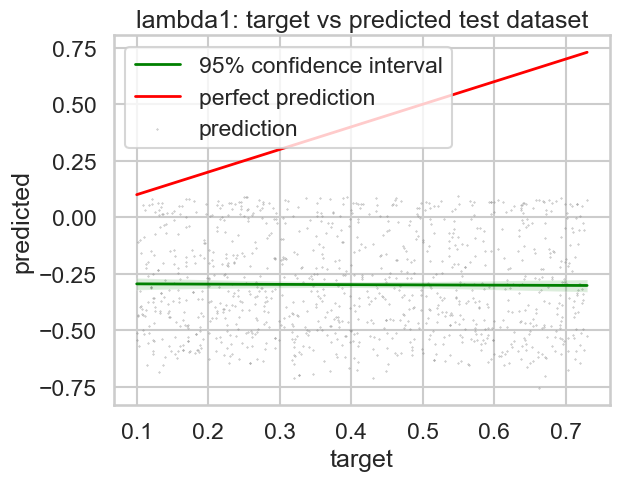

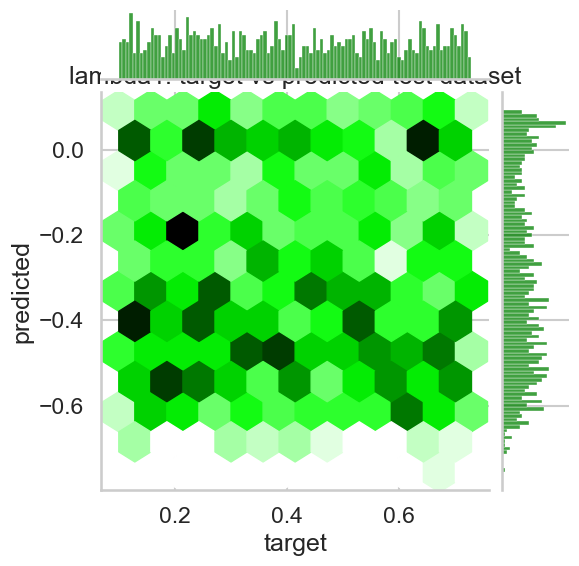

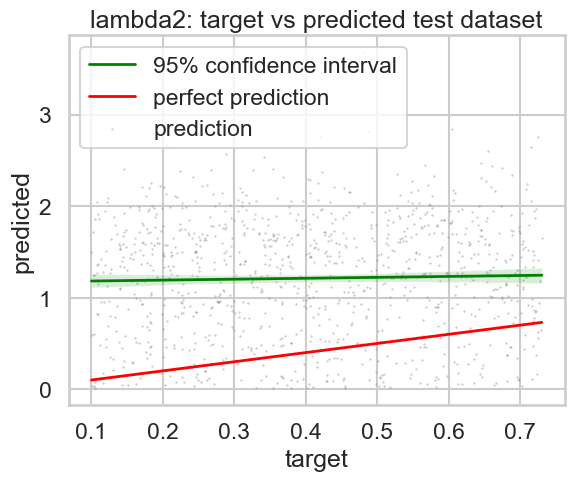

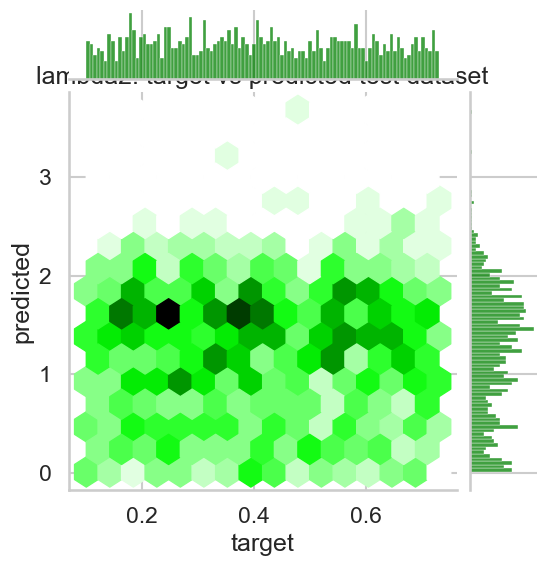

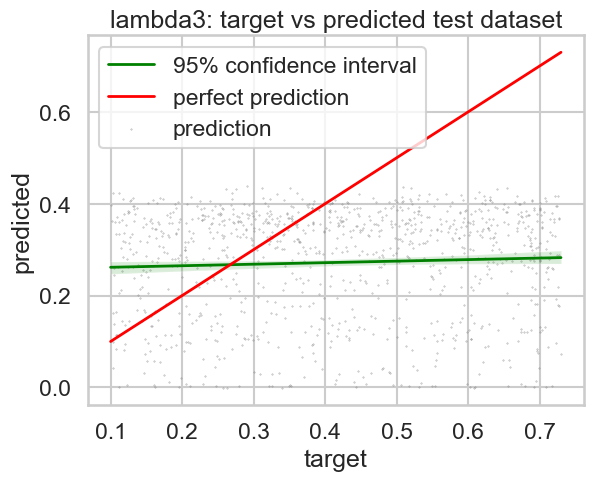

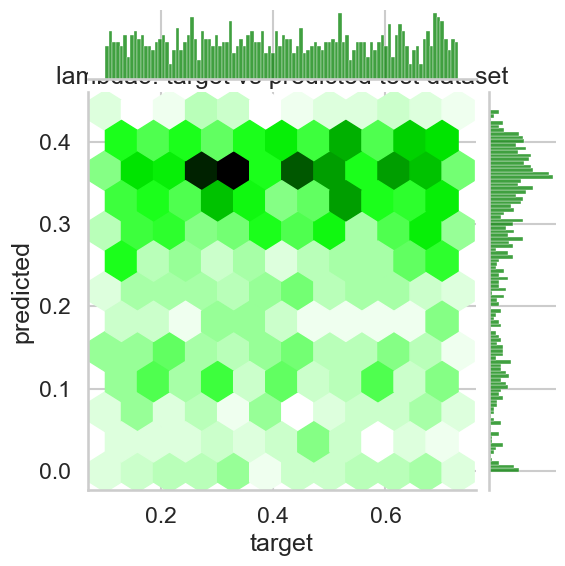

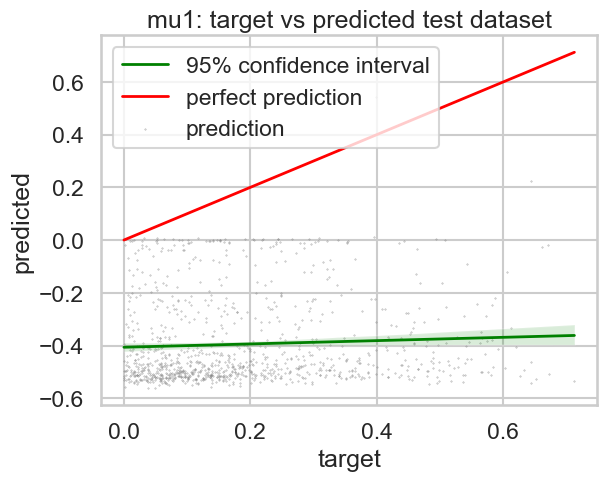

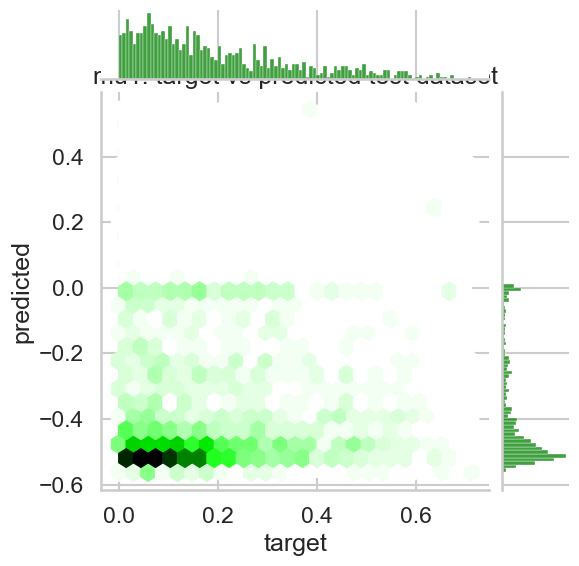

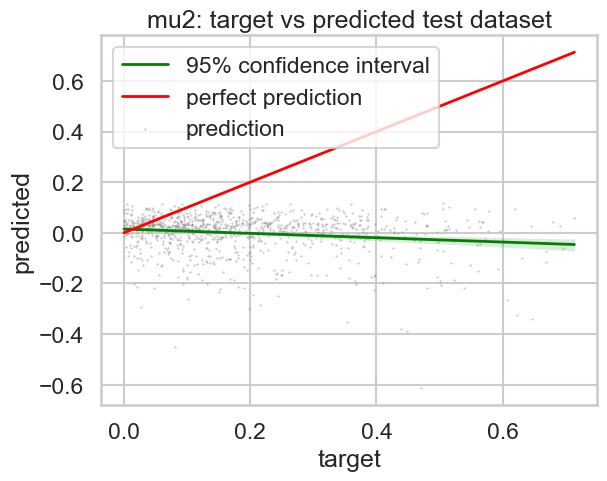

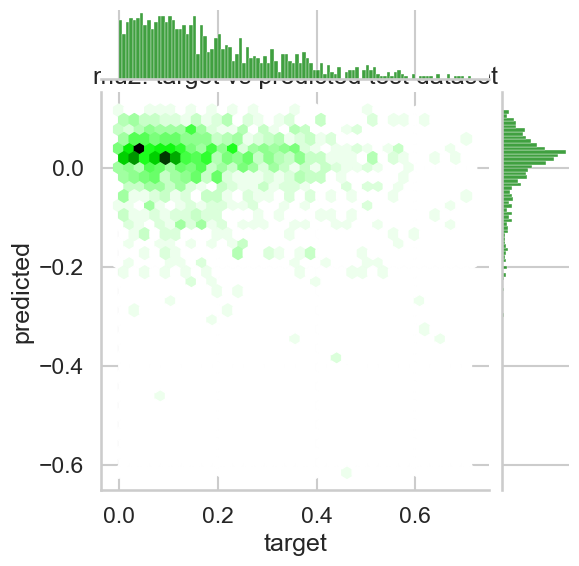

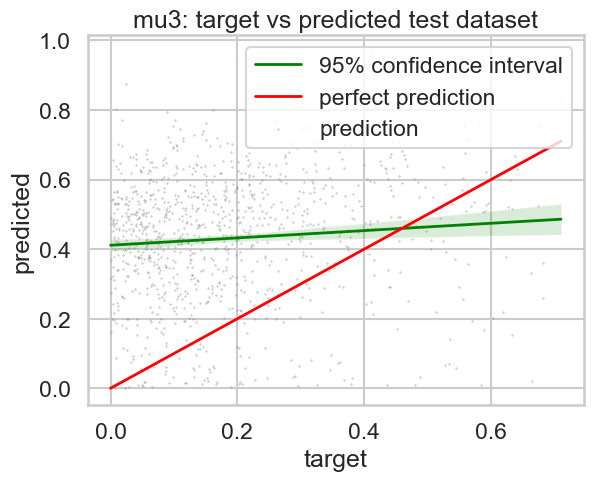

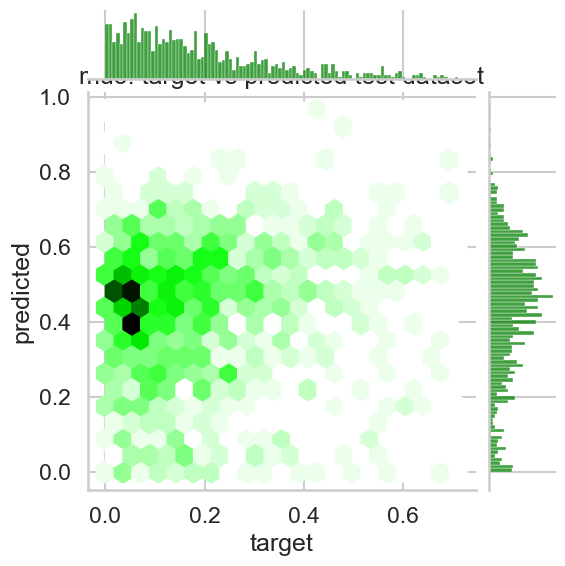

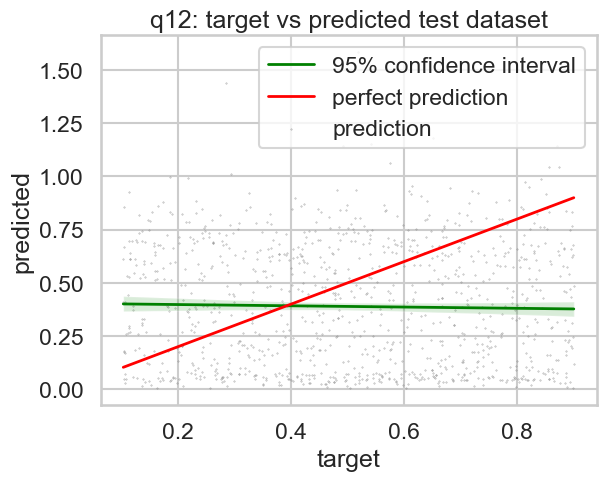

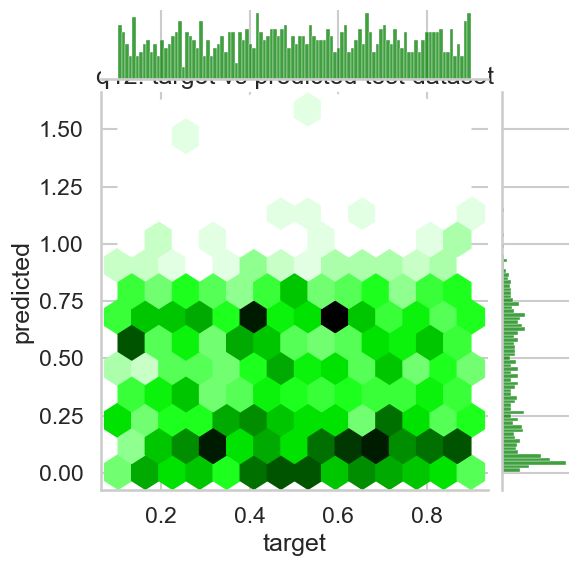

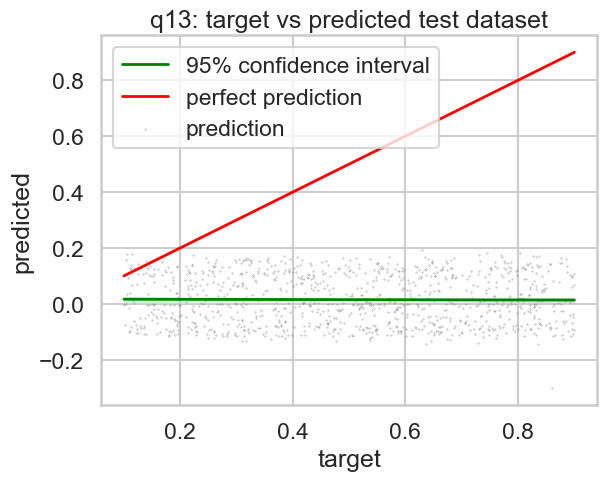

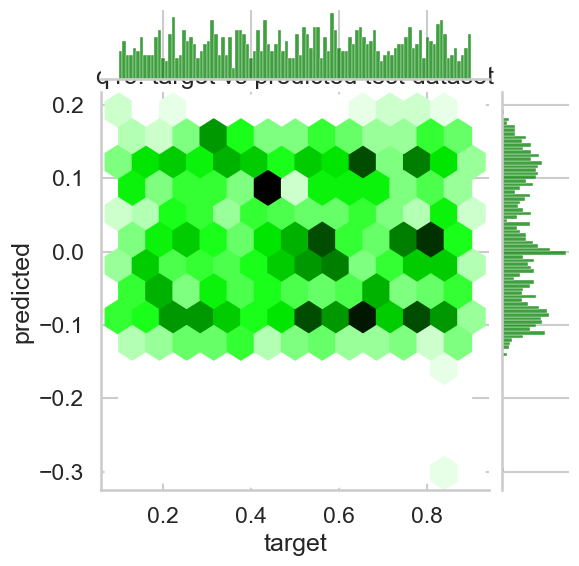

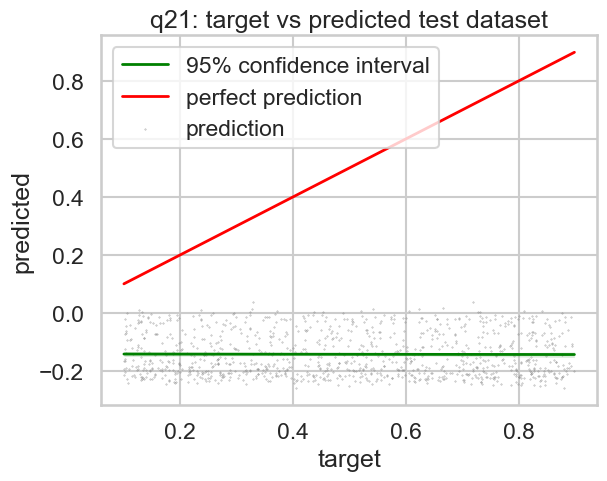

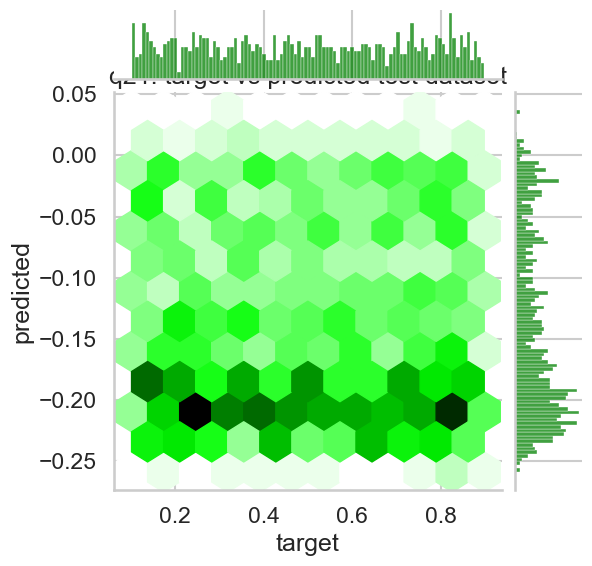

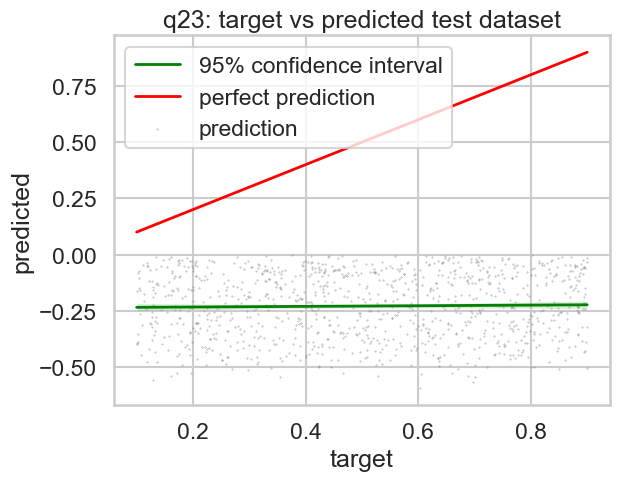

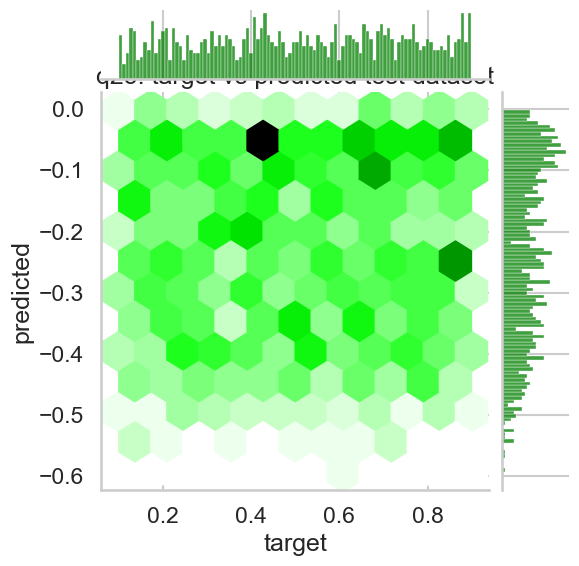

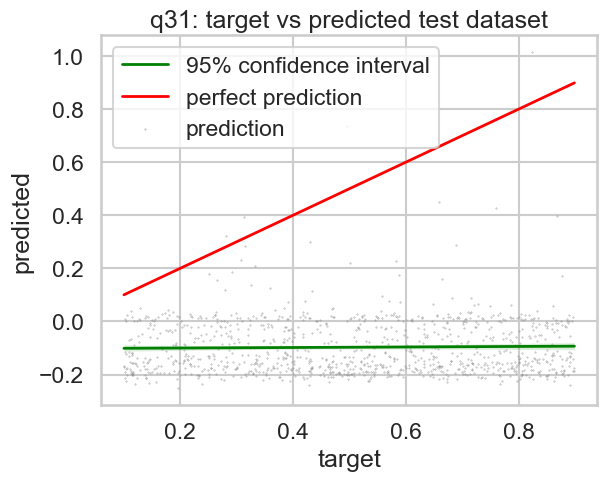

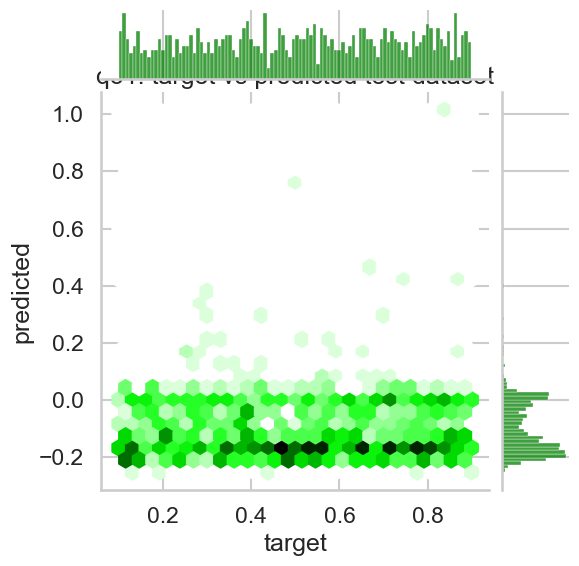

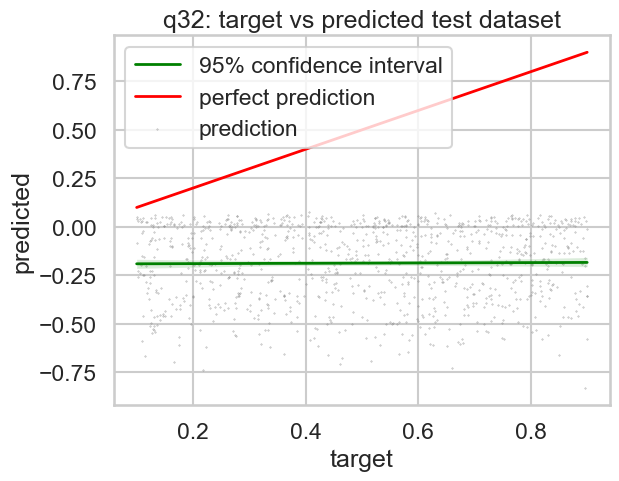

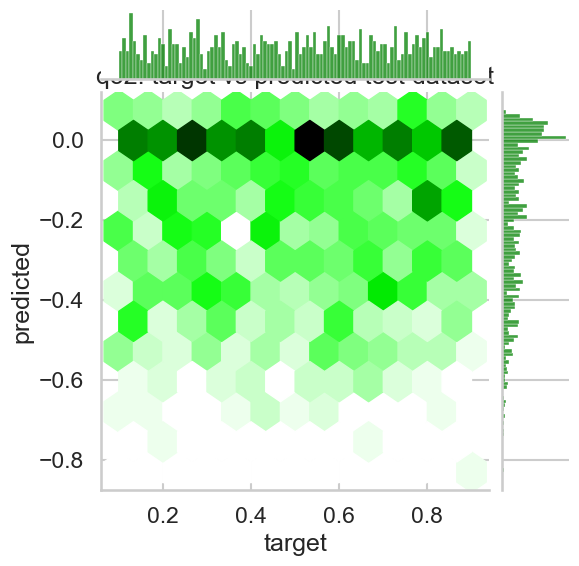

In [47]:
#import statsmodel.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

#Plot test vs predicted
# predict values for the test set
predicted_test = pd.DataFrame(estimator.predict(X_test))
predicted_test.columns = Y_test.columns # rename correctly the columns
predicted_test.index = Y_test.index # rename indexes for correspondence

elts = []

# just for subsetting columns more automatically + naming output plots
for elt in Y_test.columns:
    elts.append(elt)

for elt in elts:
    sub_df = pd.DataFrame({'predicted_minus_target_' + elt: predicted_test[elt] - Y_test[elt], 'target_'+elt: Y_test[elt], 'predicted_'+elt: predicted_test[elt]})
    if elt == elts[0]:
        df = sub_df
    else:
        sub_df.index = df.index
        df = pd.concat([df, sub_df], axis=1)
    

# fast plotting for analysis (with seaborn):
def target_vs_predicted(target_name, predicted_name, param_name, file_name_beg) : 
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=predicted_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs predicted test dataset')
    plt.xlabel('target')
    plt.ylabel('predicted')
    innerlimit = min(df[target_name])
    outerlimit = max(df[target_name])
    plt.plot([innerlimit, outerlimit], [innerlimit, outerlimit], linewidth=2, color='red', label='perfect prediction')
    plt.legend(['95% confidence interval', 'perfect prediction', 'prediction'])
    
    plt.savefig(chemin + '/' + file_name_beg + '_target_vs_predicted.png')
    plt.show()
    return None
    


for elt in elts:
    target_vs_predicted('target_'+elt, 'predicted_'+elt, elt, file_name_beg=elt)

In [21]:
# table with statistics on errors
errors_index = elts
errors_columns = ['MAE', 'RMSE', 'RME']
errors = pd.DataFrame(index=errors_index, columns=errors_columns)

def get_mae_rmse(name_var):
    predicted_vals = df['predicted_' + name_var]
    target_vals = df['target_' + name_var]
    diffs_abs = abs(target_vals - predicted_vals)
    diffs_rel = diffs_abs/target_vals
    diffs_abs_squared = diffs_abs**2
    mae = np.sum(diffs_abs)/len(diffs_abs)
    rmse = np.sqrt(sum(diffs_abs_squared)/len(diffs_abs_squared))
    rme = np.sum(diffs_rel)/len(diffs_rel)
    return mae, rmse, rme
    

#errors.loc['R_nought'] = np.array(get_mae_rmse('R_nought'))
for elt in errors_index:
    errors.loc[elt] = np.array(get_mae_rmse(elt))

print(errors)

              MAE      RMSE       RME
lambda1  0.161801  0.186884  0.579203
lambda2  0.154752  0.179929  0.530583
lambda3  0.159616  0.184354  0.586263
mu1      0.114657  0.156535   3.71954
mu2      0.108498  0.144801   3.45431
mu3      0.109164  0.151708   7.90933
q12      0.195213  0.228264  0.589315
q13      0.194823   0.22595  0.581851
q21      0.206124  0.236304  0.678575
q23      0.200334  0.232311  0.601315
q31      0.200972  0.232625  0.639925
q32      0.202562  0.233656  0.658647


In [13]:
#print differences between predicted and target as function of target: showing structural bias

def predicted_minus_target_vs_target(pr_m_tar_name, target_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=pr_m_tar_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs (target-predicted) test dataset')
    plt.xlabel('target')
    plt.ylabel('target - predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    
    plt.plot([innerlimit, outerlimit], [0, 0], linewidth=2, color='red')
    plt.show()
    return None


for elt in elts:
    predicted_minus_target_vs_target('predicted_minus_target_'+elt, 'target_'+elt, elt, file_name_beg=elt)


NameError: name 'elts' is not defined

In [23]:
#measure of correlation: predicted vs target
from scipy.stats import spearmanr, pearsonr

from sklearn.metrics import r2_score

pearson_cors = []

for elt in elts:
    pearson_cors.append(pearsonr(Y_test[elt], predicted_test[elt])[0])

print("Global pearson correlation between predicted and effective parameter: ", Y_test.columns, pearson_cors)


Global pearson correlation between predicted and effective parameter:  Index(['lambda1', 'lambda2', 'lambda3', 'mu1', 'mu2', 'mu3', 'q12', 'q13',
       'q21', 'q23', 'q31', 'q32'],
      dtype='object') [-0.05409645395827453, 0.0031035223619672796, 0.017496906929944423, 0.316862826159902, 0.27623823439259726, 0.313705733029018, 0.05911381970998568, 0.025475368090044213, -0.01926749906811104, -0.023966651260192224, -0.012838709664088963, 0.012947137783345379]


In [25]:
###save the model, weights (and scaler for sumstats only)

from tensorflow.keras.models import model_from_json

# save model
model_trial_1000 = estimator.to_json()
with open(chemin + '/model_all' + expname + '.json','w') as json_file:
    json_file.write(model_trial_1000)

# save weights
estimator.save_weights(chemin + '/model_all_weights' + expname +'.h5')
print('model saved!')

'''
#load the model
json_file = open('../Model/' + chemin + 'model_all' + expname + '.json', 'r')
loaded_file = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_file)
#load weights
loaded_model.load_weights(../Model/' + chemin + 'model_all_weights' + expname +'.h5'5)
print('model loaded!')

'''

#save scaler when there is one (FFNN-SS)
"""
from sklearn.externals import joblib

scale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'
joblib.dump(scale, scale_filename)

print('scale saved!')
#load scaler:
#scale = joblib.load(scale_filename)
"""


model saved!


"\nfrom sklearn.externals import joblib\n\nscale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'\njoblib.dump(scale, scale_filename)\n\nprint('scale saved!')\n#load scaler:\n#scale = joblib.load(scale_filename)\n"

In [ ]:
####save the predicted and the target dataframes

Y_test.to_csv(chemin + expname + 'target_all.csv', header=True)

predicted_test.to_csv(chemin + expname + 'predicted_all.csv', header=True)

## Statistics and Visualization

In [1]:
import pandas as pd
chemin = './trained_models/musse'
expname='_236_longest_known_nb_tips_absolute_error'

# Read the data
Y_test = pd.read_csv(chemin + expname + 'target_all.csv', index_col=0)
predicted_test = pd.read_csv(chemin + expname + 'predicted_all.csv', index_col=0)

In [2]:
table = pd.concat([Y_test.iloc[0], predicted_test.iloc[0]], axis=1)
table['difference'] = table.iloc[:, 0] - table.iloc[:, 1]
table['difference'] = table['difference'].apply(lambda x: f"{x:.2f}")
# set column names
table.columns = ['target', 'predicted', 'difference']
table


,target,predicted,difference
lambda1,0.229220,0.417464,-0.19
lambda2,0.443462,0.394610,0.05
lambda3,0.579132,0.433661,0.15
mu1,0.153822,0.140747,0.01
mu2,0.360397,0.141910,0.22
mu3,0.098131,0.136899,-0.04
q12,0.244552,0.492467,-0.25
q13,0.585190,0.506759,0.08
q21,0.203910,0.511527,-0.31
q23,0.770353,0.499044,0.27


,target,predicted,mean of difference
lambda1,0.408992,0.404445,0.00
lambda2,0.409256,0.397575,0.01
lambda3,0.416677,0.428515,-0.01
mu1,0.189211,0.133121,0.06
mu2,0.184919,0.147916,0.04
mu3,0.184783,0.133590,0.05
q12,0.508319,0.487060,0.02
q13,0.506417,0.491321,0.02
q21,0.496565,0.498416,-0.00
q23,0.509590,0.491159,0.02


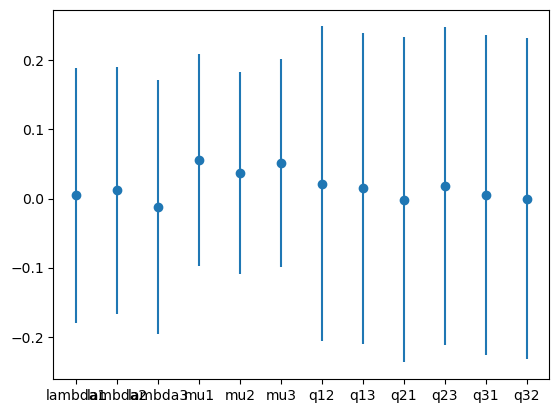

In [7]:
import matplotlib.pyplot as plt

table = pd.concat([Y_test.mean(), predicted_test.mean()], axis=1)
table['difference'] = table.iloc[:, 0] - table.iloc[:, 1]
# plot the difference between the target and the predicted values with standard deviation
upper = table['difference'] + Y_test.std()
mid = table['difference']
lower = table['difference'] - Y_test.std()
# plot
plt.errorbar(table.index, mid, yerr=[mid-lower, upper-mid], fmt='o')

table['difference'] = table['difference'].apply(lambda x: f"{x:.2f}")
table.columns = ['target', 'predicted', 'mean of difference']
# add standard deviation of the difference to the plot

table

## Tree plotting

In [5]:
import subprocess
import os
import matplotlib.pyplot as plt
from PIL import Image


# select from 

# Iterate over the first ten rows of Y_test and predicted_test
for i in range(1):
    # Define your Python lists
    y_test_list = Y_test.iloc[i].values.tolist()
    predicted_test_list = predicted_test.iloc[i].values.tolist()

    # Convert lists to strings
    y_test_str = ",".join(map(str, y_test_list))
    predicted_test_str = ",".join(map(str, predicted_test_list))
    
    max_taxa = str(30)

    try:
        # Start the R script using subprocess and pass the lists as arguments
        process = subprocess.Popen(["Rscript", "plot_trees.R", y_test_str, predicted_test_str, max_taxa],
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE,
                                   universal_newlines=True)

        # Capture and print the standard output of the R process
        stdout, stderr = process.communicate()
        print("R script output:", stdout)

        # Check if there were any errors
        if process.returncode == 0:
            print("R script executed successfully.")
        else:
            print("R script execution failed with error code:", process.returncode)
            print("Error output:", stderr)
    except FileNotFoundError:
        print("Rscript command not found. Make sure R is installed and added to the system PATH.")
    except subprocess.CalledProcessError as e:
        print("R script execution failed:", e)
    except Exception as e:
        print("An error occurred:", e)
            


Rscript command not found. Make sure R is installed and added to the system PATH.


In [26]:
# quiet mode install of PyQt5
%pip install -q pyqt5

Note: you may need to restart the kernel to use updated packages.


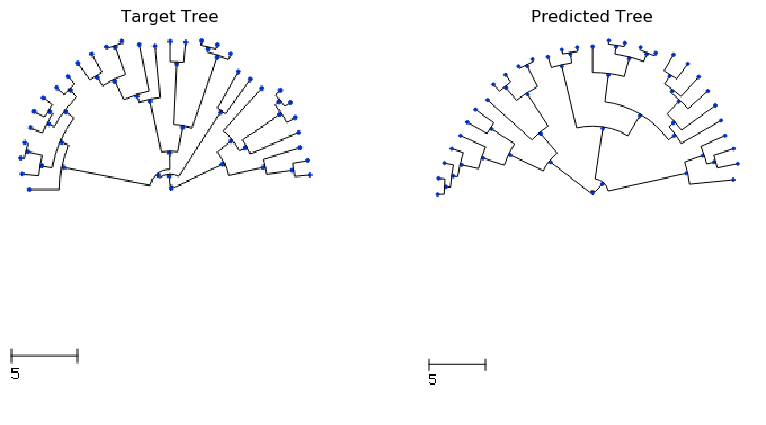

In [25]:
from ete3 import Tree, faces, TreeStyle

# read the tree from the file
target_tree = Tree("target.nwk", format=1)
predicted_tree = Tree("predicted.nwk", format=1)

# render the target tree
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.scale = 10
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180

# save the trees as images
target_tree.render("target_tree.png", tree_style=ts)
predicted_tree.render("predicted_tree.png", tree_style=ts)

# plot the trees side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open("target_tree.png"))
ax[0].axis("off")
ax[0].set_title("Target Tree")
ax[1].imshow(Image.open("predicted_tree.png"))
ax[1].axis("off")
ax[1].set_title("Predicted Tree")
plt.show()



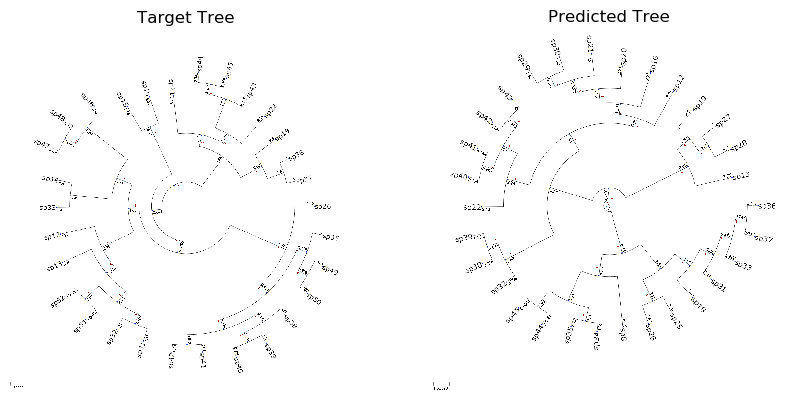

In [16]:
import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = AttrFace("name", fsize=14, fgcolor="black")
        faces.add_face_to_node(N, node, 0)
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = CircleFace(radius=node.weight, color="RoyalBlue", style="sphere")
        # Let's make the sphere transparent
        C.opacity = 0.3
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")

def get_example_tree():
    # Random tree
    t = Tree()
    t.populate(20, random_branches=True)

    # Some random features in all nodes
    for n in t.traverse():
        n.add_features(weight=random.randint(0, 50))

    # Create an empty TreeStyle
    ts = TreeStyle()

    # Set our custom layout function
    ts.layout_fn = layout

    # Draw a tree
    ts.mode = "c"

    # We will add node names manually
    ts.show_leaf_name = False
    # Show branch data
    ts.show_branch_length = True
    ts.show_branch_support = True

    return t, ts

t, ts = get_example_tree()

# save the trees as images
target_tree.render("target_tree.png", tree_style=ts)
predicted_tree.render("predicted_tree.png", tree_style=ts)

# plot the trees side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open("target_tree.png"))
ax[0].axis("off")
ax[0].set_title("Target Tree")
ax[1].imshow(Image.open("predicted_tree.png"))
ax[1].axis("off")
ax[1].set_title("Predicted Tree")
plt.show()